In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Defining the R script and loading the instance in Python

r = ro.r
r['source']('baseflow_sep.R')

R[write to console]: Loading required package: operators

R[write to console]: 
Attaching package: ‘operators’


R[write to console]: The following objects are masked from ‘package:base’:

    options, strrep


R[write to console]: Loading required package: topmodel

R[write to console]: Loading required package: DEoptim

R[write to console]: Loading required package: parallel

R[write to console]: 
DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich


R[write to console]: Loading required package: XML

R[write to console]: 
Attaching package: ‘XML’


R[write to console]: The following object is masked from ‘package:tools’:

    toHTML




value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


TLG


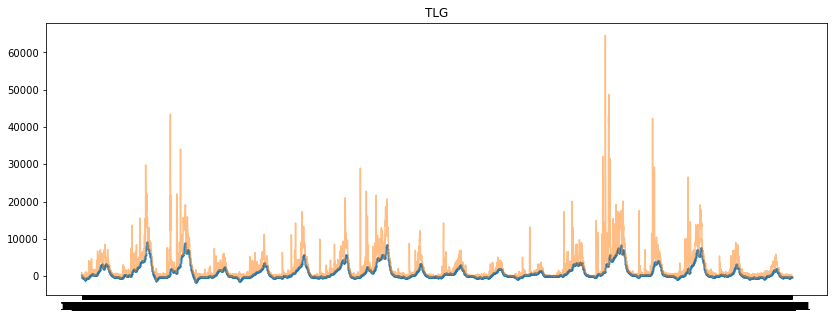

In [2]:
# Loading the function we have defined in R.
baseflow_sep = ro.globalenv['get_baseflow']

# Reading and processing data
df = pd.read_csv("../data/CDEC/tlg_runoff.csv")

df.rename(columns = {df.columns[0]: "date"}, inplace = True)
df.set_index('date', inplace = True)

# Setup results_dict
sr_dfs_out = {}
bf_dfs_out = {}

# Loop through cols 
for col in df.columns:
    print(col)

    # Select the column here 
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_pd_df = ro.conversion.py2rpy(df[col].dropna())    
        
    # Call the R function and getting the result
    runoff_df = baseflow_sep(r_pd_df)

    # Converting it back to a pandas dataframe.
    with localconverter(ro.default_converter + pandas2ri.converter):
        outdf = ro.conversion.rpy2py(runoff_df)

    outdf.index = df[col].dropna().index
#     outdf[outdf<0] = 0
    
#     outdir = "../data/baseflow_sep"
#     if not os.path.exists(outdir):
#         os.mkdir(outdir)
    
#     outfn = os.path.join(outdir, "{}_bfs.csv".format(col))
#     if not os.path.exists(outfn):
#         outdf.to_csv(outfn)
    
    bf_dfs_out[col] = outdf['bt']
    sr_dfs_out[col] = outdf['qft']
    
    plt.figure(figsize =(14,5))
    plt.title(col)
    plt.plot(outdf.index, outdf['bt'], marker = "o", markersize = 1, alpha = 0.5)
    plt.plot(outdf.index, outdf['bt'] + outdf['qft'],  markersize = 1, alpha = 0.5)
    plt.show()

In [3]:
baseflow_df = pd.DataFrame(bf_dfs_out)
surfrun_df = pd.DataFrame(sr_dfs_out)

<AxesSubplot:xlabel='date'>

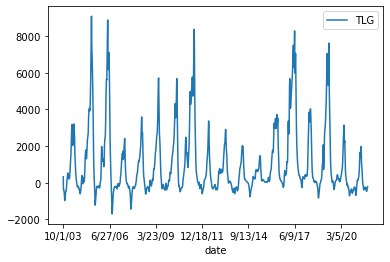

In [4]:
baseflow_df.plot()

<AxesSubplot:xlabel='date'>

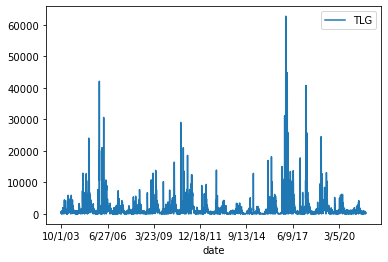

In [5]:
surfrun_df.plot()

In [7]:
# Save 
outdir = "../data/baseflow_sep"
if not os.path.exists(outdir):
    os.mkdir(outdir)

bf_outfn = os.path.join(outdir, "baseflow_mm.csv")
if not os.path.exists(bf_outfn):
    baseflow_df.to_csv(bf_outfn)

sr_outfn = os.path.join(outdir, "surface_runoff_mm.csv")
if not os.path.exists(sr_outfn):
    surfrun_df.to_csv(sr_outfn)

In [8]:
rim_date = '2013-08-17'